In [1]:
# Reading in neccessary packages
from datetime import date, timedelta
import numpy as np
import pandas as pd
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.utils import resample

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import yfinance as yf

In [2]:
# object = yf.Ticker('PEP')
# data = object.history(start="2000-01-01", end="2020-11-17")
# data.to_csv('Data/pepsi.csv')
data = pd.read_csv('Data/pepsi.csv', index_col='Date')

In [3]:
# This defines the numpy of days in the past we will use to predict the current price
LAG = 40

In [4]:
# Calculates the MSE
def mse(x, y):
    preds = model.predict(x)
    preds = scaler.inverse_transform(preds)
    unscaled_yTest = scaler.inverse_transform(np.reshape(y, (-1, 1)))
    return np.mean(np.square(preds-unscaled_yTest)), preds, unscaled_yTest

In [5]:
# This function accepts the raw data and transforms it into the form required for the LSTM NN.  
# - It removes unneccessary columns
# - scales the data between 0 and 1
# - transforms into numpy arrays
def transform(df, n=40):
    df = pd.DataFrame(df['Open'])  # Removing all the other columns as we are only predicting if we should buy based on the opening stock price

    
    # Normalizing to 0-1 range
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(df)
    df = pd.DataFrame(scaler.transform(df), columns=df.columns, index=pd.to_datetime(df.index))


    # Creating 40 columns that give the past 40 day opening stock price
    for i in range(1, n + 1):
        df[f'Open-{i}'] = df['Open'].shift(i)

    # Subsetting for the neccessary columns
    df = df.iloc[40:, 0:]

    # Splitting into training and testing data (test size is about last 2 years)
    dt = pd.to_datetime(date(2020, 11, 17) - timedelta(days=730))
    train = df[df.index < dt]
    test = df[df.index >= dt]     

    # Splitting into appropriat x and y values
    xTrain = train.iloc[:, 1:]
    yTrain = train.iloc[:, 0]
    xTest = test.iloc[:, 1:]
    yTest = test.iloc[:, 0]

    # Converting to numpy arrays to feed into model
    xTrain = xTrain.to_numpy()
    yTrain = yTrain.to_numpy()
    xTest = xTest.to_numpy()
    yTest = yTest.to_numpy()

    # Reshaping to get correct form
    xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
    xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))

    return xTrain, yTrain, xTest, yTest, scaler

In [6]:
def saveModel(model, name, location='Data'):
    # CITATION: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    # serialize model to JSON
    model_json = model.to_json()
    with open(f"{location}/{name}.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{location}/{name}.h5")
    print("Saved model to disk")

def loadModel(name, location='Data'):
    # CITATION: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    # load json and create model
    json_file = open(f"{location}/{name}.json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(f"{location}/{name}.h5")
    return model
    print("Loaded model from disk")

In [7]:
xTrain, yTrain, xTest, yTest, scaler = transform(data, LAG)

In [9]:
def modelTraining(epoch, batchSize, neuronsLSTM1=50,neuronsLSTM2=128, neuronsDense=64, learningRate=0.0005):
    with tf.device("gpu:0"):
        model = Sequential()
        model.add(LSTM(neuronsLSTM1,input_shape=(xTrain.shape[1],xTrain.shape[2])))
        model.add(Dropout(0.2))
        model.add(Dense(neuronsDense))
        model.add(Activation('sigmoid'))
        model.add(Dense(1))
        model.add(Activation('linear'))
        opt = tf.keras.optimizers.Adam(lr=learningRate)
        model.compile(optimizer=opt, loss='mse')
        model.fit(xTrain,yTrain, batch_size=batchSize, epochs=epoch, shuffle=True)
    return model

In [10]:
model = modelTraining(2000, 10)

Epoch 1/2000
472/472 [==============================] - 5s 5ms/step - loss: 0.0325
Epoch 2/2000
472/472 [==============================] - 2s 5ms/step - loss: 9.4358e-04
Epoch 3/2000
472/472 [==============================] - 3s 6ms/step - loss: 6.3211e-04
Epoch 4/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.0782e-04
Epoch 5/2000
472/472 [==============================] - 3s 5ms/step - loss: 5.7612e-04
Epoch 6/2000
472/472 [==============================] - 3s 5ms/step - loss: 6.1573e-04
Epoch 7/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.4583e-04
Epoch 8/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.8162e-04
Epoch 9/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.9228e-04
Epoch 10/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.3483e-04
Epoch 11/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.9212e-04
Epoch 12/2000
472/472 [======================

472/472 [==============================] - 2s 5ms/step - loss: 1.6555e-04
Epoch 95/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.8634e-04
Epoch 96/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.8687e-04
Epoch 97/2000
472/472 [==============================] - 2s 5ms/step - loss: 2.0476e-04
Epoch 98/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.9427e-04
Epoch 99/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.9489e-04
Epoch 100/2000
472/472 [==============================] - 3s 6ms/step - loss: 1.7857e-04
Epoch 101/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.7921e-04
Epoch 102/2000
472/472 [==============================] - 2s 5ms/step - loss: 2.4189e-04
Epoch 103/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.7177e-04
Epoch 104/2000
472/472 [==============================] - 2s 5ms/step - loss: 2.1249e-04
Epoch 105/2000
472/472 [=================

472/472 [==============================] - 2s 5ms/step - loss: 1.9222e-04
Epoch 187/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.2564e-04
Epoch 188/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.2287e-04
Epoch 189/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.2447e-04
Epoch 190/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.2300e-04
Epoch 191/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.2532e-04
Epoch 192/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.4299e-04
Epoch 193/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.1541e-04
Epoch 194/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.1016e-04
Epoch 195/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.5704e-04
Epoch 196/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.2523e-04
Epoch 197/2000
472/472 [============

472/472 [==============================] - 3s 6ms/step - loss: 9.8168e-05
Epoch 279/2000
472/472 [==============================] - 2s 5ms/step - loss: 9.8919e-05
Epoch 280/2000
472/472 [==============================] - 2s 5ms/step - loss: 8.4250e-05
Epoch 281/2000
472/472 [==============================] - 2s 5ms/step - loss: 9.5743e-05
Epoch 282/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.0229e-04
Epoch 283/2000
472/472 [==============================] - 2s 5ms/step - loss: 8.5859e-05
Epoch 284/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.0013e-04
Epoch 285/2000
472/472 [==============================] - 2s 5ms/step - loss: 8.2338e-05
Epoch 286/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.1031e-04
Epoch 287/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.0570e-04
Epoch 288/2000
472/472 [==============================] - 2s 5ms/step - loss: 8.9186e-05
Epoch 289/2000
472/472 [============

472/472 [==============================] - 2s 5ms/step - loss: 8.2625e-05
Epoch 371/2000
472/472 [==============================] - 2s 5ms/step - loss: 9.6801e-05
Epoch 372/2000
472/472 [==============================] - 2s 5ms/step - loss: 8.4353e-05
Epoch 373/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.6786e-05
Epoch 374/2000
472/472 [==============================] - 2s 5ms/step - loss: 8.0236e-05
Epoch 375/2000
472/472 [==============================] - 2s 5ms/step - loss: 8.9356e-05
Epoch 376/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.8444e-05
Epoch 377/2000
472/472 [==============================] - 3s 6ms/step - loss: 9.8308e-05
Epoch 378/2000
472/472 [==============================] - 3s 6ms/step - loss: 7.4715e-05
Epoch 379/2000
472/472 [==============================] - 3s 5ms/step - loss: 7.0410e-05
Epoch 380/2000
472/472 [==============================] - 2s 5ms/step - loss: 8.4559e-05
Epoch 381/2000
472/472 [============

472/472 [==============================] - 2s 5ms/step - loss: 7.3836e-05
Epoch 462/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.5763e-05
Epoch 463/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.1342e-05
Epoch 464/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.2944e-05
Epoch 465/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.4232e-05
Epoch 466/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.1222e-05
Epoch 467/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.7139e-05
Epoch 468/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.3775e-05
Epoch 469/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.3603e-05
Epoch 470/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.4325e-05
Epoch 471/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.1031e-05
Epoch 472/2000
472/472 [============

472/472 [==============================] - 2s 5ms/step - loss: 6.9964e-05
Epoch 554/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.5541e-05
Epoch 555/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.6985e-05
Epoch 556/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.2980e-05
Epoch 557/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.4826e-05
Epoch 558/2000
472/472 [==============================] - 2s 5ms/step - loss: 1.1403e-04
Epoch 559/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.8060e-05
Epoch 560/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.2922e-05
Epoch 561/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.4350e-05
Epoch 562/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.6783e-05
Epoch 563/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.1260e-05
Epoch 564/2000
472/472 [============

472/472 [==============================] - 2s 5ms/step - loss: 5.9360e-05
Epoch 646/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.8635e-05
Epoch 647/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.8668e-05
Epoch 648/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.1089e-05
Epoch 649/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.6220e-05
Epoch 650/2000
472/472 [==============================] - 2s 5ms/step - loss: 7.4585e-05
Epoch 651/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.0829e-05
Epoch 652/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.8293e-05
Epoch 653/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.1140e-05
Epoch 654/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.8098e-05
Epoch 655/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.5929e-05
Epoch 656/2000
472/472 [============

472/472 [==============================] - 2s 5ms/step - loss: 7.3525e-05
Epoch 738/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.0179e-05
Epoch 739/2000
472/472 [==============================] - 3s 5ms/step - loss: 5.5789e-05
Epoch 740/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.1153e-05
Epoch 741/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.0470e-05
Epoch 742/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.6951e-05
Epoch 743/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.0549e-05
Epoch 744/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.6996e-05
Epoch 745/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.3242e-05
Epoch 746/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.8177e-05
Epoch 747/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.7577e-05
Epoch 748/2000
472/472 [============

472/472 [==============================] - 2s 5ms/step - loss: 5.1230e-05
Epoch 830/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.3205e-05
Epoch 831/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.5930e-05
Epoch 832/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.4698e-05
Epoch 833/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.9186e-05
Epoch 834/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.6068e-05
Epoch 835/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.0126e-05
Epoch 836/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.1290e-05
Epoch 837/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.8027e-05
Epoch 838/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.9384e-05
Epoch 839/2000
472/472 [==============================] - 2s 5ms/step - loss: 6.8449e-05
Epoch 840/2000
472/472 [============

472/472 [==============================] - 3s 6ms/step - loss: 5.4481e-05
Epoch 922/2000
472/472 [==============================] - 3s 5ms/step - loss: 5.0074e-05
Epoch 923/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.0517e-05
Epoch 924/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.7276e-05
Epoch 925/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.3482e-05
Epoch 926/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.0591e-05
Epoch 927/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.6789e-05
Epoch 928/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.7388e-05
Epoch 929/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.9951e-05
Epoch 930/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.9743e-05
Epoch 931/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.8109e-05
Epoch 932/2000
472/472 [============

472/472 [==============================] - 2s 5ms/step - loss: 7.1221e-05
Epoch 1014/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.3449e-05
Epoch 1015/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.0930e-05
Epoch 1016/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.0716e-05
Epoch 1017/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.2501e-05
Epoch 1018/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.3654e-05
Epoch 1019/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.9580e-05
Epoch 1020/2000
472/472 [==============================] - 2s 5ms/step - loss: 5.0736e-05
Epoch 1021/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.7902e-05
Epoch 1022/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.5960e-05
Epoch 1023/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.4071e-05
Epoch 1024/2000
472/472 [=

472/472 [==============================] - 2s 5ms/step - loss: 5.0299e-05
Epoch 1105/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.4814e-05
Epoch 1106/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.6302e-05
Epoch 1107/2000
472/472 [==============================] - 3s 5ms/step - loss: 4.8146e-05
Epoch 1108/2000
472/472 [==============================] - 3s 5ms/step - loss: 4.3142e-05
Epoch 1109/2000
472/472 [==============================] - 3s 6ms/step - loss: 4.8816e-05
Epoch 1110/2000
472/472 [==============================] - 3s 7ms/step - loss: 4.8605e-05
Epoch 1111/2000
472/472 [==============================] - 3s 7ms/step - loss: 3.9738e-05
Epoch 1112/2000
472/472 [==============================] - 3s 6ms/step - loss: 4.0643e-05
Epoch 1113/2000
472/472 [==============================] - 3s 7ms/step - loss: 4.2591e-05
Epoch 1114/2000
472/472 [==============================] - 3s 7ms/step - loss: 4.1783e-05
Epoch 1115/2000
472/472 [=

472/472 [==============================] - 2s 5ms/step - loss: 4.3586e-05
Epoch 1196/2000
472/472 [==============================] - 3s 5ms/step - loss: 4.5837e-05
Epoch 1197/2000
472/472 [==============================] - 3s 6ms/step - loss: 4.0343e-05
Epoch 1198/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.6325e-05
Epoch 1199/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.2848e-05
Epoch 1200/2000
472/472 [==============================] - ETA: 0s - loss: 4.3667e-0 - 3s 5ms/step - loss: 4.3661e-05
Epoch 1201/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.0145e-05
Epoch 1202/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.3489e-05
Epoch 1203/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.8897e-05
Epoch 1204/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.4674e-05
Epoch 1205/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.4904e-0

472/472 [==============================] - 3s 6ms/step - loss: 4.0425e-05
Epoch 1286/2000
472/472 [==============================] - 3s 6ms/step - loss: 3.7495e-05
Epoch 1287/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.3942e-05
Epoch 1288/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.1127e-05
Epoch 1289/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.3836e-05
Epoch 1290/2000
472/472 [==============================] - 3s 5ms/step - loss: 3.8635e-05
Epoch 1291/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.5270e-05
Epoch 1292/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.1662e-05
Epoch 1293/2000
472/472 [==============================] - 3s 5ms/step - loss: 4.2539e-05
Epoch 1294/2000
472/472 [==============================] - 3s 5ms/step - loss: 5.2652e-05
Epoch 1295/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.9877e-05
Epoch 1296/2000
472/472 [=

472/472 [==============================] - 2s 5ms/step - loss: 3.7303e-05
Epoch 1376/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.4216e-05
Epoch 1377/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.7355e-05
Epoch 1378/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.9816e-05
Epoch 1379/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.6769e-05
Epoch 1380/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.0252e-05
Epoch 1381/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.6343e-05
Epoch 1382/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.8683e-05
Epoch 1383/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.5378e-05
Epoch 1384/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.0819e-05
Epoch 1385/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.1158e-05
Epoch 1386/2000
472/472 [=

472/472 [==============================] - 2s 5ms/step - loss: 3.8803e-05
Epoch 1466/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.5815e-05
Epoch 1467/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.9683e-05
Epoch 1468/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.5435e-05
Epoch 1469/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.6043e-05
Epoch 1470/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.7099e-05
Epoch 1471/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.7254e-05
Epoch 1472/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.7596e-05
Epoch 1473/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.2671e-05
Epoch 1474/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.2108e-05
Epoch 1475/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.9256e-05
Epoch 1476/2000
472/472 [=

472/472 [==============================] - 2s 5ms/step - loss: 3.7376e-05
Epoch 1557/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.8218e-05
Epoch 1558/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.5362e-05
Epoch 1559/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.5722e-05
Epoch 1560/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.7033e-05
Epoch 1561/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.2092e-05
Epoch 1562/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.7303e-05
Epoch 1563/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.3244e-05
Epoch 1564/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.5500e-05
Epoch 1565/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.8102e-05
Epoch 1566/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.3106e-05
Epoch 1567/2000
472/472 [=

472/472 [==============================] - 2s 5ms/step - loss: 4.4877e-05
Epoch 1648/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.9452e-05
Epoch 1649/2000
472/472 [==============================] - 3s 6ms/step - loss: 3.6068e-05
Epoch 1650/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.0449e-05
Epoch 1651/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.6019e-05
Epoch 1652/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.7619e-05
Epoch 1653/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.8004e-05
Epoch 1654/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.4506e-05
Epoch 1655/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.6811e-05
Epoch 1656/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.4393e-05
Epoch 1657/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.4179e-05
Epoch 1658/2000
472/472 [=

472/472 [==============================] - 2s 5ms/step - loss: 3.4178e-05
Epoch 1739/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.4080e-05
Epoch 1740/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.6661e-05
Epoch 1741/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.6179e-05
Epoch 1742/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.4115e-05
Epoch 1743/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.4356e-05
Epoch 1744/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.4943e-05
Epoch 1745/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.6378e-05
Epoch 1746/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.1614e-05
Epoch 1747/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.2350e-05
Epoch 1748/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.3865e-05
Epoch 1749/2000
472/472 [=

472/472 [==============================] - 2s 5ms/step - loss: 3.3461e-05
Epoch 1830/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.3557e-05
Epoch 1831/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.8508e-05
Epoch 1832/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.7066e-05
Epoch 1833/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.3768e-05
Epoch 1834/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.3579e-05
Epoch 1835/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.2397e-05
Epoch 1836/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.4389e-05
Epoch 1837/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.3341e-05
Epoch 1838/2000
472/472 [==============================] - 2s 5ms/step - loss: 4.8538e-05
Epoch 1839/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.6184e-05
Epoch 1840/2000
472/472 [=

472/472 [==============================] - 2s 5ms/step - loss: 3.2630e-05
Epoch 1921/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.5628e-05
Epoch 1922/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.1106e-05
Epoch 1923/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.8275e-05
Epoch 1924/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.4071e-05
Epoch 1925/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.2825e-05
Epoch 1926/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.4485e-05
Epoch 1927/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.1093e-05
Epoch 1928/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.3282e-05
Epoch 1929/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.4120e-05
Epoch 1930/2000
472/472 [==============================] - 2s 5ms/step - loss: 3.3666e-05
Epoch 1931/2000
472/472 [=

MSE Train: 0.3905062042188134
MSE Test: 364.5141882238961


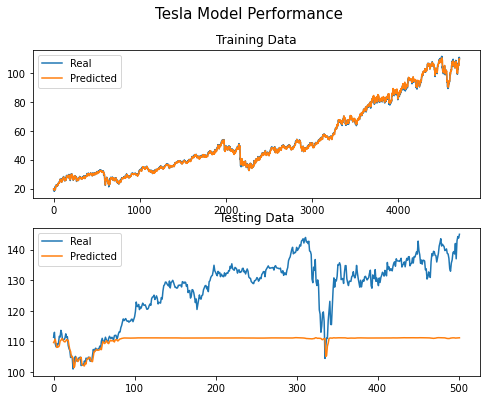

In [15]:
mseTrain, yHat, y = mse(xTrain,yTrain)
print("MSE Train:", mseTrain)

fig, axes = plt.subplots(2, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('Tesla Model Performance', fontsize=15)

# Top Left Subplot
axes[0].plot(y)
axes[0].plot(yHat)
axes[0].set_title("Training Data")
axes[0].legend(['Real', 'Predicted'])


mseTest, yHat, y = mse(xTest,yTest)

print("MSE Test:", mseTest)
# Top Right Subplot
axes[1].plot(y)
axes[1].plot(yHat)
axes[1].set_title("Testing Data")
axes[1].legend(['Real', 'Predicted'])

In [12]:
saveModel(model, "pepsiComplete", location='Data')

Saved model to disk


array([[[0.01238774],
        [0.01386721],
        [0.01771381],
        ...,
        [0.02629461],
        [0.02984528],
        [0.02422344]],

       [[0.00824528],
        [0.01238774],
        [0.01386721],
        ...,
        [0.02126446],
        [0.02629461],
        [0.02984528]],

       [[0.01150008],
        [0.00824528],
        [0.01238774],
        ...,
        [0.03132473],
        [0.02126446],
        [0.02629461]],

       ...,

       [[0.73215513],
        [0.72657936],
        [0.7197396 ],
        ...,
        [0.71364332],
        [0.70598587],
        [0.70390416]],

       [[0.72985041],
        [0.73215513],
        [0.72657936],
        ...,
        [0.70501932],
        [0.71364332],
        [0.70598587]],

       [[0.72234168],
        [0.72985041],
        [0.73215513],
        ...,
        [0.69416513],
        [0.70501932],
        [0.71364332]]])